In [6]:
%matplotlib inline
from ultralytics import YOLO
import pandas as pd
import re
import numpy as np
import cv2
import math
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

In [7]:

def open_video(video_path):
    vid=list()
    cap=cv2.VideoCapture(video_path)
    frameCount = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frameWidth = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frameHeight = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # buf = np.empty((frameCount, frameHeight, frameWidth, 3), np.dtype('uint8'))
    # fc=0
    while True:
        ret, frame = cap.read()
        if not ret: break # break if no next frame
        
        # buf[fc]=frame # append frame
        # fc+=1
        vid.append(frame)
    # release and destroy windows
    cap.release()
    cv2.destroyAllWindows()
    return vid


    

In [8]:
def frame_height(vid):
    frame=vid[0]
    height=len(frame)
    return height
def frame_width(vid):
    frame=vid[0]
    width=len(frame[0])
    return width

In [9]:
def save_video(vid,name):
    fourcc = cv2.VideoWriter_fourcc(*'MP4V')
    frame_width=len(vid[0][0])
    frame_height=len(vid[0])
    out = cv2.VideoWriter(name, fourcc, 25.0, (frame_width, frame_height))
    for frame in vid:
        out.write(frame)
    out.release

In [10]:
def suppress_duplicates(detections):
    # assuming your data frame is named `detections`
    # and has the columns `Frame`, `Class`, and `Confidence`

    # group by frame number and class name
    groups = detections.groupby(['Frame', 'Class'])

    # filter rows to keep only the detection with the highest confidence score for each group
    filtered_detections = groups.apply(lambda x: x.loc[x['Confidence'].idxmax()])

    # reset index of the filtered data frame
    filtered_detections = filtered_detections.reset_index(drop=True)
    
    return filtered_detections

In [11]:
def detect(vid):
    model=YOLO('v2.pt')
    results=model(vid)
    df=pd.DataFrame(columns=["Frame","Class","Confidence","Xmin","Ymin","Xmax","Ymax","Xc","Yc","W","H","A"])
    for result in results:
        for box in result.boxes:
            xyxy=box.xyxy.numpy()[0]
            xywh=box.xywh.numpy()[0]
            frame_number=int(re.search('(?<=image)\d+',result.path).group())
            cls="Bat" if box.cls==2 else "Ball" if box.cls==0 else "Batsman"
            df.loc[len(df)]=[frame_number,cls,int(float(box.conf)*100),xyxy[0],xyxy[1],xyxy[2],xyxy[3],xywh[0],xywh[1],xywh[2],xywh[3],xywh[2]*xywh[3]]
    return suppress_duplicates(df)

In [12]:
def calculate_distances(detections):
    bat_ball = detections.loc[detections['Class'].isin(['Bat', 'Ball'])]

    # group rows by Frame
    groups = bat_ball.groupby('Frame')

    # compute distance between Bat and Ball coordinates for each group
    distances = []
    for name, group in groups:
        bat_coords = group.loc[group['Class'] == 'Bat', ['Xc', 'Yc']].values
        ball_coords = group.loc[group['Class'] == 'Ball', ['Xc', 'Yc']].values
        if len(bat_coords) > 0 and len(ball_coords) > 0:
            # distance = np.linalg.norm(bat_coords - ball_coords)
            distance=math.dist(bat_coords[0],ball_coords[0])
            distances.append((name, distance))

    # create a new data frame with the distances
    distances_df = pd.DataFrame(distances, columns=['Frame', 'Distance'])
    return distances_df

def detect_impact_frame(detections):
    distances_df=calculate_distances(detections)
    f_impact=distances_df.loc[distances_df['Distance'].idxmin()]["Frame"]
    return int(f_impact)


In [13]:
def detect_bounce_frame(detections,f_impact):
    ball_detections=detections.loc[(detections["Class"]=="Ball") & (detections["Frame"]<f_impact)]#class is ball and frame is before impact frame
    f_bounce=ball_detections.loc[ball_detections['Yc'].idxmax()]["Frame"]#get point where y-axis is max
    return int(f_bounce)

In [14]:
def visualize_bounding_boxes(detections, vid, classes):
    # create a list to store the output frames
    output_frames = []
    
    # loop over each frame in the video
    for frame_number, frame in enumerate(vid):
        # create a copy of the frame
        output_frame = np.copy(frame)
        
        # select rows for the specified classes
        selected_rows = detections[detections['Class'].isin(classes) & (detections['Frame'] == frame_number)]
        
        # loop over the selected rows and draw bounding boxes on the output frame
        for index, row in selected_rows.iterrows():
            class_name = row['Class']
            xmin = int(row['Xmin'])
            ymin = int(row['Ymin'])
            xmax = int(row['Xmax'])
            ymax = int(row['Ymax'])
            color = (0, 255, 0)  # set the color for the bounding box
            
            # draw the bounding box on the output frame
            cv2.rectangle(output_frame, (xmin, ymin), (xmax, ymax), color, 2)
            cv2.putText(output_frame, class_name, (xmin, ymin - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
        
        # add the output frame to the list of output frames
        output_frames.append(output_frame)
    
    # return the list of output frames
    return output_frames

In [61]:
def estimate_bowling_side(detections):
    bat_ball = detections.loc[detections['Class'].isin(['Ball', 'Batsman'])]

    # group rows by Frame
    groups = bat_ball.groupby('Frame')

    # compute distance between Bat and Ball coordinates for each group
    distances = []
    for name, group in groups:
        batsman_coords = group.loc[group['Class'] == 'Batsman', ['Xc', 'Yc']].values
        ball_coords = group.loc[group['Class'] == 'Ball', ['Xc', 'Yc']].values
        if len(batsman_coords) > 0 and len(ball_coords) > 0:
            # distance = np.linalg.norm(bat_coords - ball_coords)
            x_vect=batsman_coords[0][0]-ball_coords[0][0]
            if x_vect>0:
                return "LEFT"
            else:
                return "RIGHT"

In [74]:

def unzoom(x,y,detections,frame):
    d_height=191
    f_height=int(detections.loc[(detections["Class"].isin(["Batsman"]))&(detections["Frame"]==frame)]["H"])
    zf=f_height/d_height
    x/=zf
    y/=zf
    return (int(x),int(y))

In [19]:
def horizontal_plane(x,y):
    return (x,y,0)
def vertical_plane(x,y):
    return (x,0,y)

In [48]:

def calc_coords_of_ball_relative_to_batsman(detections,cls,f):
    Batsman=detections.loc[detections["Class"].isin(["Batsman"]) & (detections["Frame"]==f)]
    Ball=detections.loc[detections["Class"].isin([cls]) & (detections["Frame"]==f)]
    P_X_Batsman=(Batsman["Xmin"]+Batsman["Xmax"])/2
    P_Y_Batsman=Batsman["Ymax"]
    X=int(Ball['Xc'])-int(P_X_Batsman)
    # Y=(frame_height(vid)-int(Ball['Yc']))-(frame_height(vid)-int(Batsman['Yc']))
    Y=int(P_Y_Batsman)-int(Ball['Yc'])
    return (X,Y)


In [68]:
def estimate_release_point(bowlingSide):
    if "LEFT":
        return (-83,-321,229)
    else:
        return (83,-321,229)
        

In [21]:
vid=open_video('7.2.23/1.mp4')

In [22]:
detections=detect(vid)

In [23]:
detections

,Unnamed: 0,Frame,Class,Confidence,Xmin,...,Xc,Yc,W,H,A
0,0,0,Bat,69,905.0,...,928.5,289.0,47.0,42.0,1974.0
1,1,0,Batsman,92,905.0,...,947.5,312.5,85.0,191.0,16235.0
2,2,1,Bat,65,901.0,...,926.0,287.0,50.0,42.0,2100.0
3,3,1,Batsman,93,902.0,...,946.0,313.5,88.0,193.0,16984.0
4,4,2,Bat,64,899.0,...,924.5,285.5,51.0,45.0,2295.0
...,...,...,...,...,...,...,...,...,...,...,...
79,79,33,Ball,78,1718.0,...,1732.0,407.5,28.0,25.0,700.0
80,80,33,Bat,74,964.0,...,997.0,254.0,66.0,238.0,15708.0
81,81,33,Batsman,94,802.0,...,912.5,449.5,221.0,629.0,139009.0
82,82,34,Bat,73,952.0,...,983.0,261.0,62.0,274.0,16988.0


In [24]:
f_impact=detect_impact_frame(detections)

In [25]:
f_bounce=detect_bounce_frame(detections,f_impact)

bounce point: ((-28, -141, 0))
impact point: ((11, 0, 101))
after impact point: ((85, 0, 120))
player origin: ((0, 0, 0))
release point: ((-83, -321, 229))
corner point: ((-140, 0, 0))
corner point: ((140, 0, 0))
corner point: ((166, -321, 0))
corner point: ((166, -321, 0))


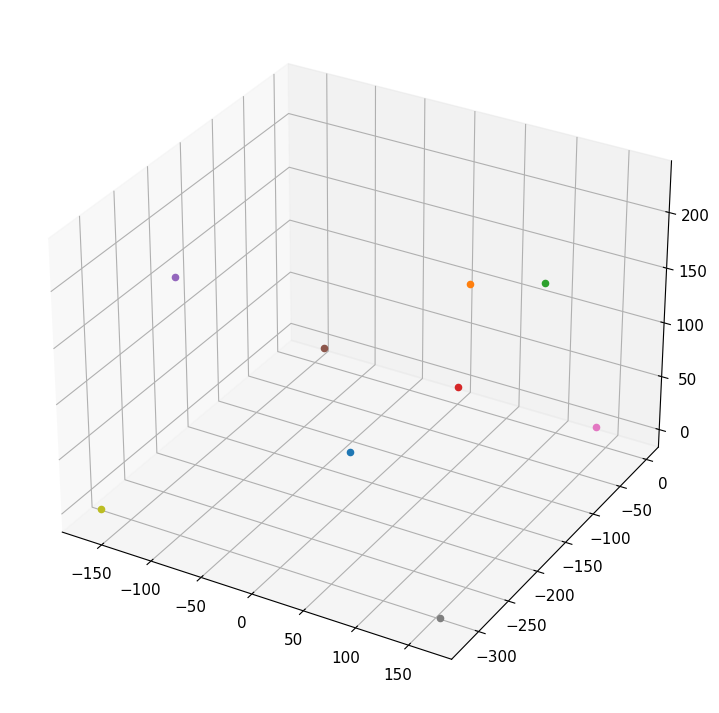

In [75]:
# Creating figure
fig = plt.figure(figsize = (16, 9))
ax = plt.axes(projection ="3d")
   
# Add x, y gridlines
ax.grid(b = True, color ='grey',
        linestyle ='-.', linewidth = 0.3,
        alpha = 0.2)
 
 
# Creating color map
my_cmap = plt.get_cmap('hsv')

bowling_side=estimate_bowling_side(detections)

(X,Y)=calc_coords_of_ball_relative_to_batsman(detections,"Ball",f_bounce)
(X,Y)=unzoom(X,Y,detections,f_bounce)
ax.scatter3D(X, Y, 0)#bounce point
print(f"bounce point: {X,Y,0}")
# plt.scatter(X,Y,,0.color="red")
(X,Y)=calc_coords_of_ball_relative_to_batsman(detections,"Ball",f_impact)

(X,Y)=unzoom(X,Y,detections,f_impact)
ax.scatter3D(X, 0, Y)#impact point
print(f"impact point: {X,0,Y}")

(X,Y)=calc_coords_of_ball_relative_to_batsman(detections,"Ball",f_impact+1)
(X,Y)=unzoom(X,Y,detections,f_impact)
ax.scatter3D(X, 0, Y)#after impact point
print(f"after impact point: {X,0,Y}")

ax.scatter3D(0, 0, 0)#player
print(f"player origin: {0,0,0}")

(X,Y,Z)=estimate_release_point(bowling_side)
ax.scatter3D(X,Y,Z)#release
print(f"release point: {X,Y,Z}")


ax.scatter3D(-140,0,0)#corner points
print(f"corner point: {-140,0,0}")
ax.scatter3D(140,0,0)#corner points
print(f"corner point: {140,0,0}")
ax.scatter3D(166, -321,0)#corner points
print(f"corner point: {166,-321,0}")
ax.scatter3D(-166, -321,0)#corner points
print(f"corner point: {166,-321,0}")

# ax.scatter3D(-143,6,0)
# ax.scatter3D(137,6,0)
# ax.scatter3D(161, -327,0)
# ax.scatter3D(-171, -327,0)

# plt.scatter(X,,0,Y,color="green")
# ax.scatter3D(0, 0, 0)
# plt.scatter(0,0,color="blue")
plt.show()

In [28]:
ball=detections.loc[detections["Class"]=="Ball"]

In [29]:
print(bowlerSideEstimation(detections))

LEFT


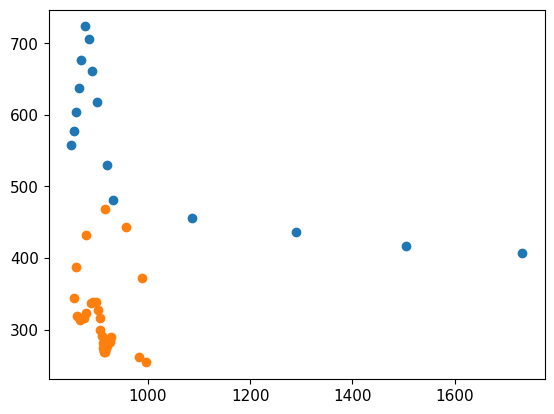

In [30]:
%matplotlib inline
ball=detections.loc[detections["Class"]=="Ball"]
bat=detections.loc[detections["Class"]=="Bat"]
import matplotlib.pyplot as plt
plt.scatter(ball["Xc"],ball["Yc"])
plt.scatter(bat["Xc"],bat["Yc"])
plt.show()


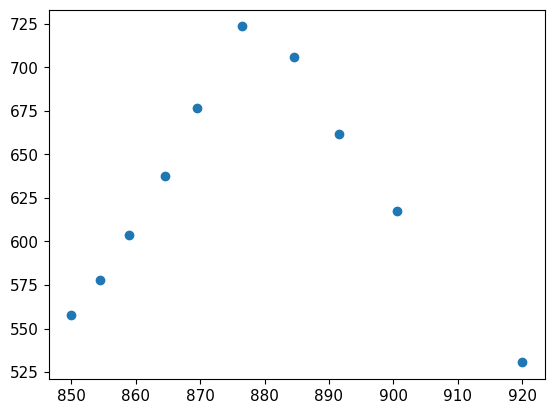

In [31]:
%matplotlib inline
ball=detections.loc[(detections["Class"]=="Ball") & (detections["Frame"]<f_impact)]#class is ball and frame is before impact frame
import matplotlib.pyplot as plt
plt.scatter(ball["Xc"],ball["Yc"])
plt.show()


In [32]:
f_bounce=detect_bounce_frame(detections,f_impact)

In [33]:
f_bounce

23

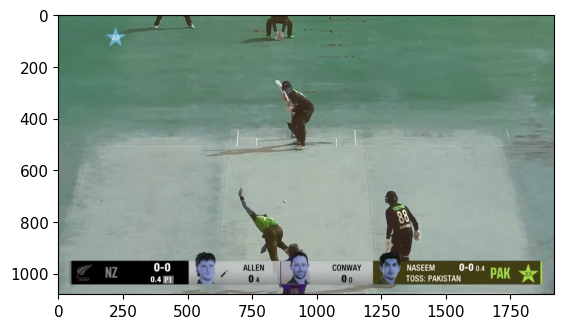

In [34]:
plt.imshow(vid[f_bounce])

DONT RUN EXPERIMENTAL SCRIPTS

In [35]:
# import os
# _, _, files = next(os.walk("29.3.23"))
# file_count = len(files)
# print(files)

In [36]:
# for i in range(1,44):
#     vid=open_video(f'29.3.23/{i}.mp4')
#     detections=detect(vid)
#     detections.to_csv(f'runs/detections/29.3.23/{i}.csv')

In [37]:
# import matplotlib.pyplot as plt
# for i in range(1,44):
#     detections=pd.read_csv(f'runs/detections/29.3.23/{i}.csv')
#     ball=detections.loc[detections["Class"]=="Ball"]
#     bat=detections.loc[detections["Class"]=="Bat"]
#     plt.plot(ball["Xc"],ball["Yc"])
#     plt.plot(bat["Xc"],bat["Yc"])
#     plt.savefig(f'runs/plots/line/29.3.23/{i}.png',format='png')
#     plt.close()
#     print(i)

In [38]:
# import matplotlib.pyplot as plt
# for i in range(1,44):
#     detections=pd.read_csv(f'runs/detections/29.3.23/{i}.csv')
#     ball=detections.loc[detections["Class"]=="Ball"]
#     bat=detections.loc[detections["Class"]=="Bat"]
#     plt.scatter(ball["Xc"],ball["Yc"])
#     plt.scatter(bat["Xc"],bat["Yc"])
#     plt.savefig(f'runs/plots/scatter/29.3.23/{i}.png',format='png')
#     plt.close()
#     print(i)

In [39]:
# import matplotlib.pyplot as plt
# for i in range(1,44):
#     detections=pd.read_csv(f'runs/detections/29.3.23/{i}.csv')
#     f_impact=detect_impact_frame(detections)
#     ball=detections.loc[(detections["Class"]=="Ball") & (detections["Frame"]<f_impact)]
#     plt.scatter(ball["Xc"],ball["Yc"])
#     plt.savefig(f'runs/plots/after_rejection/29.3.23/{i}.png',format='png')
#     plt.close()
#     print(i)

In [40]:
# for i in range(1,44):
#     detections=pd.read_csv(f'runs/detections/29.3.23/{i}.csv')
#     vid=open_video(f'29.3.23/{i}.mp4')
#     f_impact=detect_impact_frame(detections)
#     f_bounce=detect_bounce_frame(detections,f_impact)
#     # print(f'{f_impact},{f_bounce}')
#     plt.imsave(f'runs/validate/impact/29.3.23/{i}.jpg',vid[f_impact])
#     plt.imsave(f'runs/validate/bounce/29.3.23/{i}.jpg',vid[f_bounce])
#     plt.close()
#     print(i)

In [41]:
# for i in range(1,44):
#     detections=pd.read_csv(f'runs/detections/29.3.23/{i}.csv')
#     vid=open_video(f'29.3.23/{i}.mp4')
#     classes=["Bat","Ball"]
#     viz_vid=visualize_bounding_boxes(detections,vid,classes)
#     save_video(viz_vid,f"runs/visualized/29.3.23/{i}.mp4")
#     print(i)

In [42]:
# import os
# for i in range(1,44):
#     detections=pd.read_csv(f'runs/detections/29.3.23/{i}.csv')
#     vid=open_video(f'29.3.23/{i}.mp4')
#     classes=["Bat","Ball","Batman"]
#     viz_vid=visualize_bounding_boxes(detections,vid,classes)
#     os.makedirs(f"runs/visualize/frame/29.3.23/{i}")
#     for j in range(len(viz_vid)):
#         plt.imsave(f'runs/visualize/frame/29.3.23/{i}/{j}.jpg',viz_vid[j])
#     print(i)

In [46]:

def calc_coords_of_ball_relative_to_batsman(x,y,detections,f):
    Batsman=detections.loc[detections["Class"].isin(["Batsman"]) & (detections["Frame"]==f)]
    P_X_Batsman=(Batsman["Xmin"]+Batsman["Xmax"])/2
    P_Y_Batsman=Batsman["Ymax"]
    X=int(x)-int(P_X_Batsman)
    # Y=(frame_height(vid)-int(Ball['Yc']))-(frame_height(vid)-int(Batsman['Yc']))
    Y=int(P_Y_Batsman)-int(y)
    return (X,Y)

calc_coords_of_ball_relative_to_batsman(776,735,detections,0)

(-171, -327)

In [53]:
d_height=191
f_height=int(detections.loc[(detections["Class"].isin(["Batsman"]))&(detections["Frame"]==16)]["H"])
zf=f_height/d_height
print(zf)

1.12565445026178


In [67]:
258/zf

229.20000000000002